In [1]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle


# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox


# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    new_df = pd.read_csv(path1) 
elif os.path.exists(path2):
    new_df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [3]:
new_df.head(2)

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label,Complaint_Count_diff1
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1,NaN
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1,2.0


In [4]:
new_df["time"] = pd.to_datetime(new_df["time"])


In [5]:
df = new_df.drop(columns=['relative_humidity_2m_mean','weather_label','month','year', 'Complaint_Count_diff1'])

In [6]:
df['day_of_month'] = df['time'].dt.day
df['day_of_year'] = df['time'].dt.dayofyear

In [7]:
df

,time,temp_max_C,precip_mm,day_of_week,wind_speed_max_m_s,Complaint_Count,day_of_month,day_of_year
0,2022-06-10,41.0,0.1,4,16.6,10,10,161
1,2022-06-11,41.0,0.2,5,25.3,12,11,162
2,2022-06-12,39.8,0.0,6,16.7,5,12,163
3,2022-06-13,40.2,0.0,0,13.3,15,13,164
4,2022-06-14,39.2,8.6,1,19.0,16,14,165
...,...,...,...,...,...,...,...,...
1178,2025-10-15,31.4,0.0,2,6.1,18,15,288
1179,2025-10-16,30.9,0.0,3,8.2,18,16,289
1180,2025-10-17,31.0,0.0,4,7.8,17,17,290
1181,2025-10-18,30.5,0.0,5,6.3,37,18,291


### Convert day-based features into sine–cosine cyclical form

In [8]:
# Day of Week (7 days cycle)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Day of Month (approx 31 days cycle)
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

# Day of Year (365 days cycle)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [9]:
df.drop(['day_of_week', 'day_of_month', 'day_of_year'], axis=1, inplace=True)

In [10]:
df.head(2)

,time,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
0,2022-06-10,41.0,0.1,16.6,10,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
1,2022-06-11,41.0,0.2,25.3,12,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377


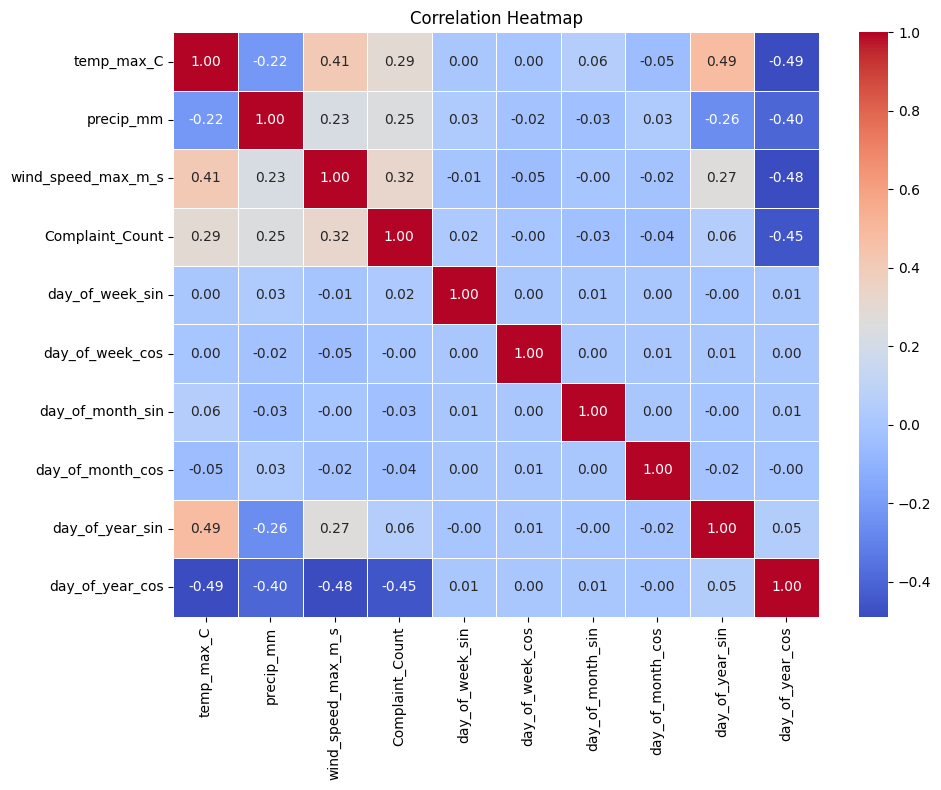

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


              Feature       VIF
0          temp_max_C  2.624115
9     day_of_year_cos  2.563106
1           precip_mm  1.702598
8     day_of_year_sin  1.630460
2  wind_speed_max_m_s  1.537061
3     Complaint_Count  1.313762
6    day_of_month_sin  1.008475
7    day_of_month_cos  1.005843
5     day_of_week_cos  1.004376
4     day_of_week_sin  1.003133


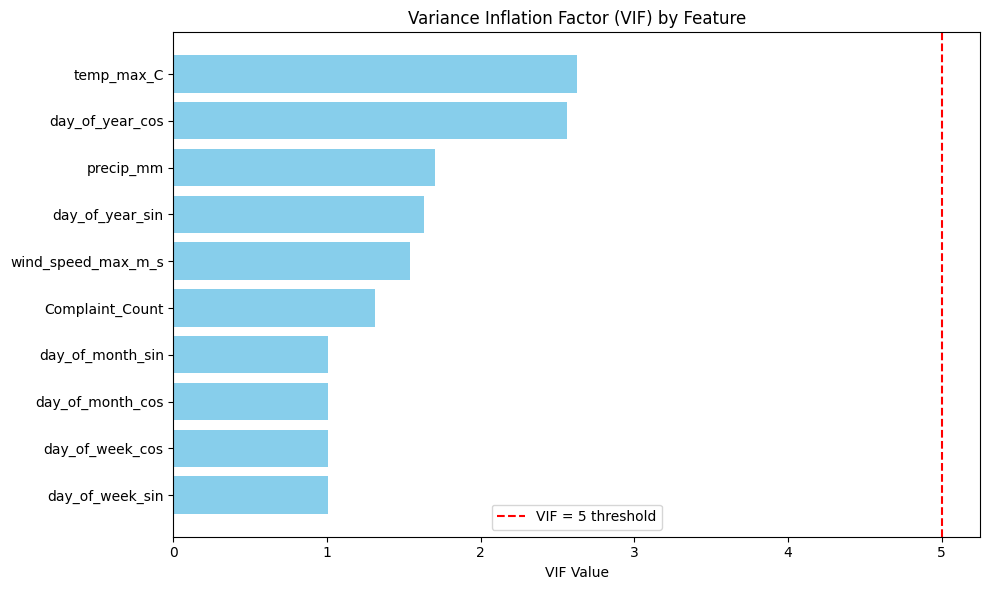

In [12]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Load and preprocess
df_numeric = df.select_dtypes(include='number').dropna()

# Optional: scale features for stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))


import matplotlib.pyplot as plt

# Sort for better visual impact
vif_data_sorted = vif_data.sort_values("VIF", ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(vif_data_sorted["Feature"], vif_data_sorted["VIF"], color="skyblue")
plt.axvline(x=5, color="red", linestyle="--", label="VIF = 5 threshold")
plt.xlabel("VIF Value")
plt.title("Variance Inflation Factor (VIF) by Feature")
plt.legend()
plt.tight_layout()
plt.show()




In [13]:
df.set_index('time', inplace=True)

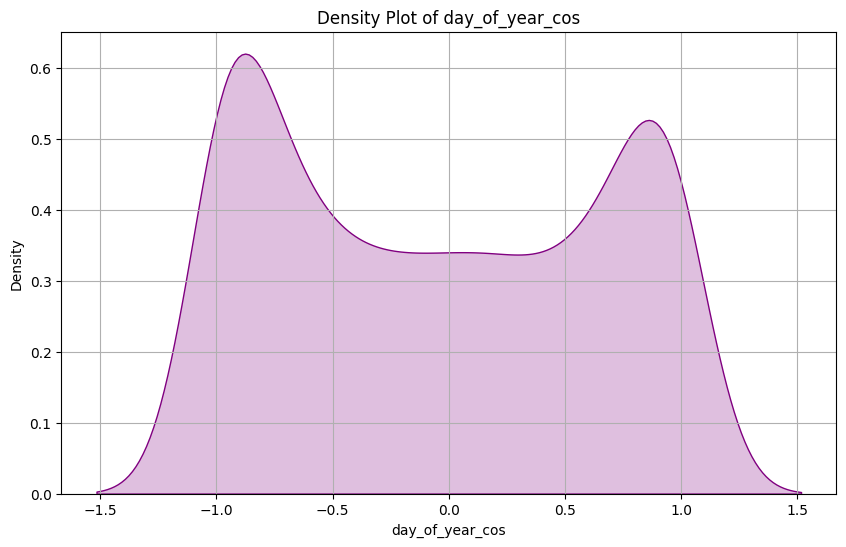

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['day_of_year_cos'], fill=True, color='purple')
plt.title('Density Plot of day_of_year_cos')
plt.xlabel('day_of_year_cos')
plt.ylabel('Density')
plt.grid(True)
plt.show()

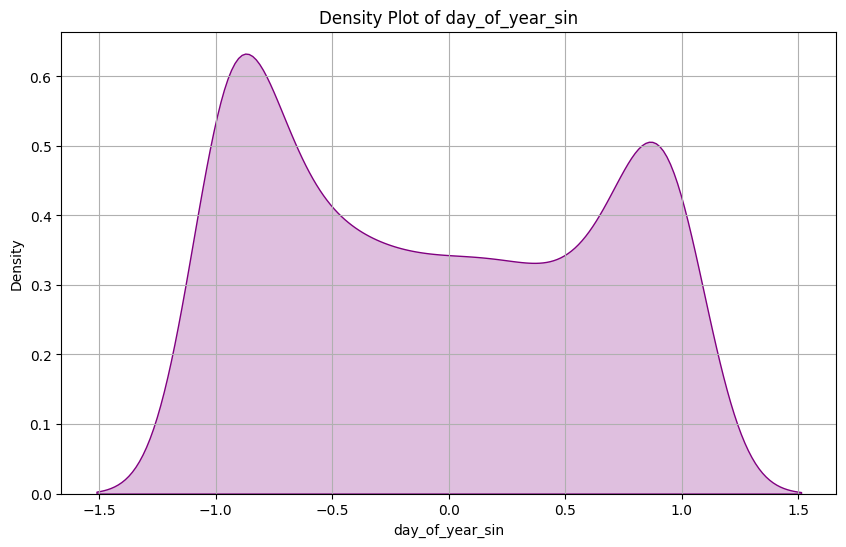

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['day_of_year_sin'], fill=True, color='purple')
plt.title('Density Plot of day_of_year_sin')
plt.xlabel('day_of_year_sin')
plt.ylabel('Density')
plt.grid(True)
plt.show()

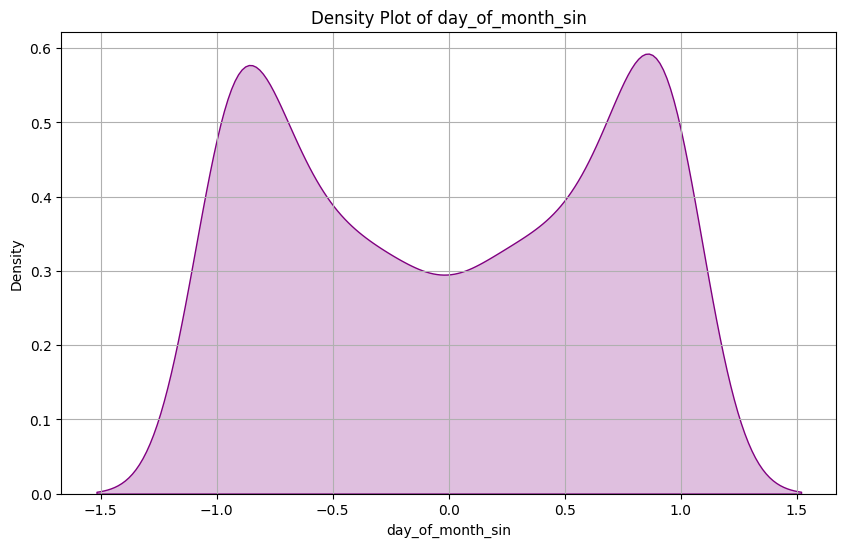

In [16]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['day_of_month_sin'], fill=True, color='purple')
plt.title('Density Plot of day_of_month_sin')
plt.xlabel('day_of_month_sin')
plt.ylabel('Density')
plt.grid(True)
plt.show()

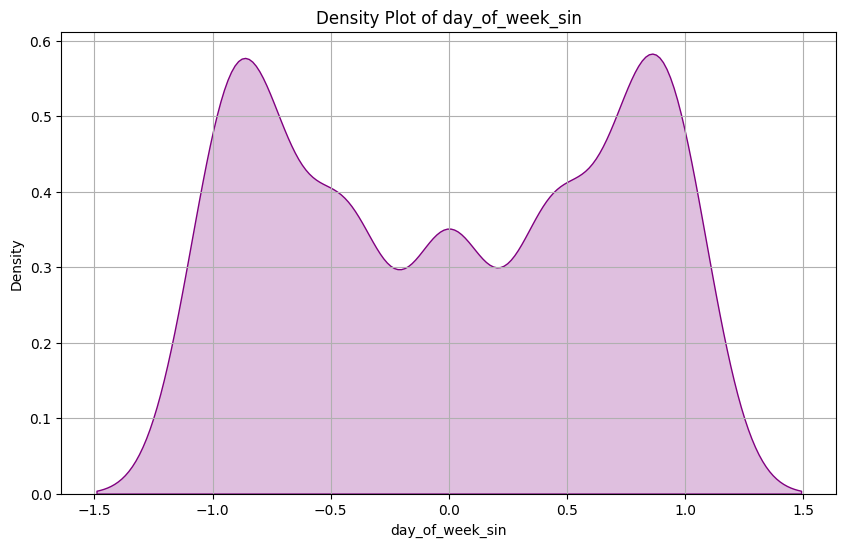

In [17]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['day_of_week_sin'], fill=True, color='purple')
plt.title('Density Plot of day_of_week_sin')
plt.xlabel('day_of_week_sin')
plt.ylabel('Density')
plt.grid(True)
plt.show()

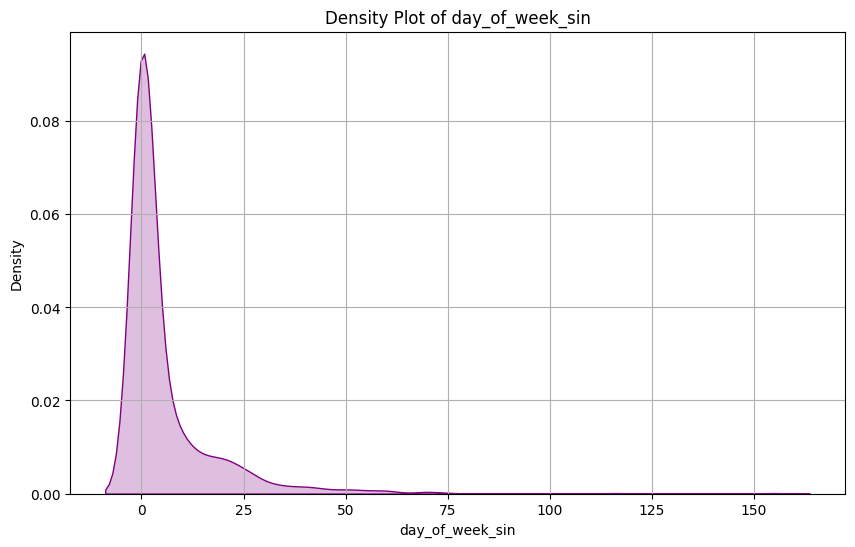

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['precip_mm'], fill=True, color='purple')
plt.title('Density Plot of day_of_week_sin')
plt.xlabel('day_of_week_sin')
plt.ylabel('Density')
plt.grid(True)
plt.show()

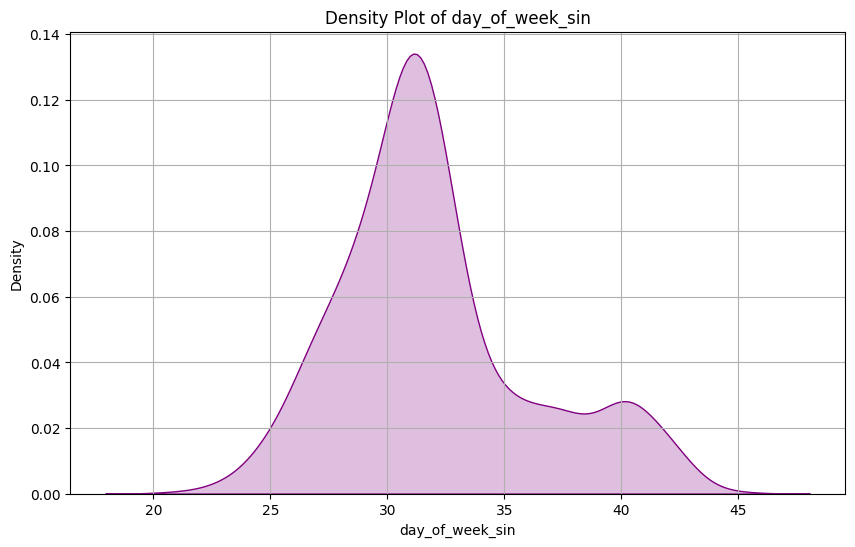

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['temp_max_C'], fill=True, color='purple')
plt.title('Density Plot of day_of_week_sin')
plt.xlabel('day_of_week_sin')
plt.ylabel('Density')
plt.grid(True)
plt.show()

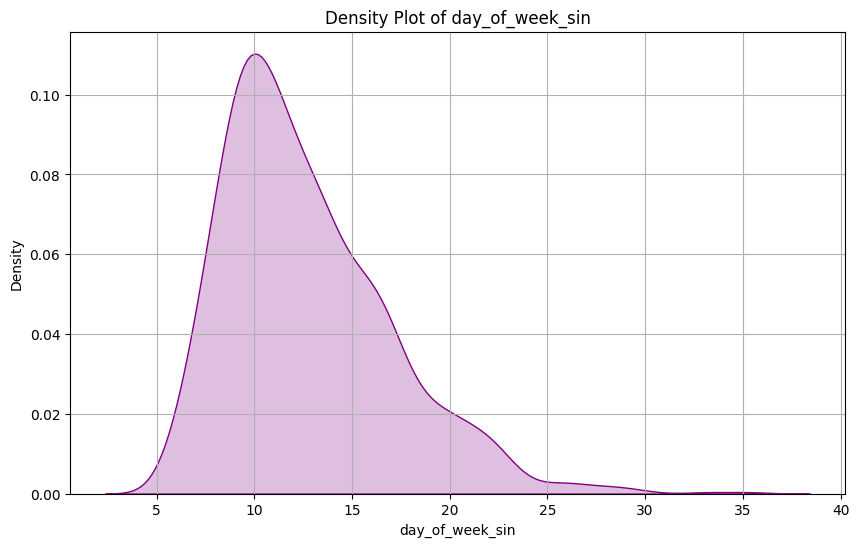

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['wind_speed_max_m_s'], fill=True, color='purple')
plt.title('Density Plot of day_of_week_sin')
plt.xlabel('day_of_week_sin')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [21]:
df.head()

,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
time,,,,,,,,,,
2022-06-10,41.0,0.1,16.6,10,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
2022-06-11,41.0,0.2,25.3,12,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377
2022-06-12,39.8,0.0,16.7,5,-0.781831,0.623490,0.651372,-0.758758,0.329408,-0.944188
2022-06-13,40.2,0.0,13.3,15,0.000000,1.000000,0.485302,-0.874347,0.313107,-0.949718
2022-06-14,39.2,8.6,19.0,16,0.781831,0.623490,0.299363,-0.954139,0.296713,-0.954967


In [22]:
# Columns to scale
scale_cols = ['temp_max_C', 'precip_mm', 'wind_speed_max_m_s',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos']
# Initialize scaler
scaler = MinMaxScaler()
# Fit on selected columns and transform
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [23]:
df.head()

,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
time,,,,,,,,,,
2022-06-10,0.833333,0.000646,0.372483,10,0.277479,0.000000,0.949479,0.277951,0.680859,0.033837
2022-06-11,0.833333,0.001292,0.664430,12,0.000000,0.356896,0.895896,0.191874,0.672808,0.030793
2022-06-12,0.783333,0.000000,0.375839,5,0.099031,0.801938,0.826105,0.118359,0.664706,0.027888
2022-06-13,0.800000,0.000000,0.261745,15,0.500000,1.000000,0.742963,0.060416,0.656555,0.025123
2022-06-14,0.758333,0.055556,0.453020,16,0.900969,0.801938,0.649874,0.020417,0.648358,0.022499


In [24]:
df.columns

Index(['temp_max_C', 'precip_mm', 'wind_speed_max_m_s', 'Complaint_Count',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [25]:
# Separate features (X) and target (y)
X = df.drop(columns=['Complaint_Count'])
y = df['Complaint_Count']
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.9)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Date range - Train: {df.index[0]} to {df.index[train_size-1]}")
print(f"Date range - Test: {df.index[train_size]} to {df.index[-1]}")

X_train shape: (1064, 9)
X_test shape: (119, 9)
y_train shape: (1064,)
y_test shape: (119,)
Training set size: 1064
Test set size: 119
Date range - Train: 2022-06-10 00:00:00 to 2025-06-17 00:00:00
Date range - Test: 2025-06-18 00:00:00 to 2025-10-19 00:00:00


In [26]:
best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, 7)

final_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(final_model.summary())

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                   Complaint_Count   No. Observations:                 1064
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4044.919
Date:                           Fri, 31 Oct 2025   AIC                           8117.838
Time:                                   23:22:13   BIC                           8187.189
Sample:                                        0   HQIC                          8144.137
                                          - 1064                                         
Covariance Type:                             opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
temp_max_C            -2.8061      4.901     -0.573      0.567     -12.412       6.800
precip_mm          

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
y_pred = final_model.predict(start=len(y_train),end=len(y_train) + len(y_test) - 1, exog=X_test)

# Combine results
forecast_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred.values,
}, index=y_test.index)

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
forecast_df.head(1)

,Actual,Predicted
time,,
2025-06-18,75,75.72384


In [29]:
# Ensure both y_test and y_pred are numpy arrays and aligned properly
y_true = np.array(y_test)
y_pred_values = np.array(y_pred)

# Core metrics
mae = mean_absolute_error(y_true, y_pred_values)
mse = mean_squared_error(y_true, y_pred_values)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_values)

# Safe MAPE calculation (exclude zero or negative actuals)
non_zero_mask = y_true != 0
if np.any(non_zero_mask):  # Avoid division by zero
    mape = (np.abs((y_true[non_zero_mask] - y_pred_values[non_zero_mask]) / y_true[non_zero_mask]).mean()) * 100
else:
    mape = np.nan  # or handle gracefully

# Display
print("\n📊 Model Evaluation Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape:.2f}%")


📊 Model Evaluation Metrics:
MAE   : 329.7037
MSE   : 154279.5040
RMSE  : 392.7843
R²    : -618.6704
MAPE  : 1028.18%


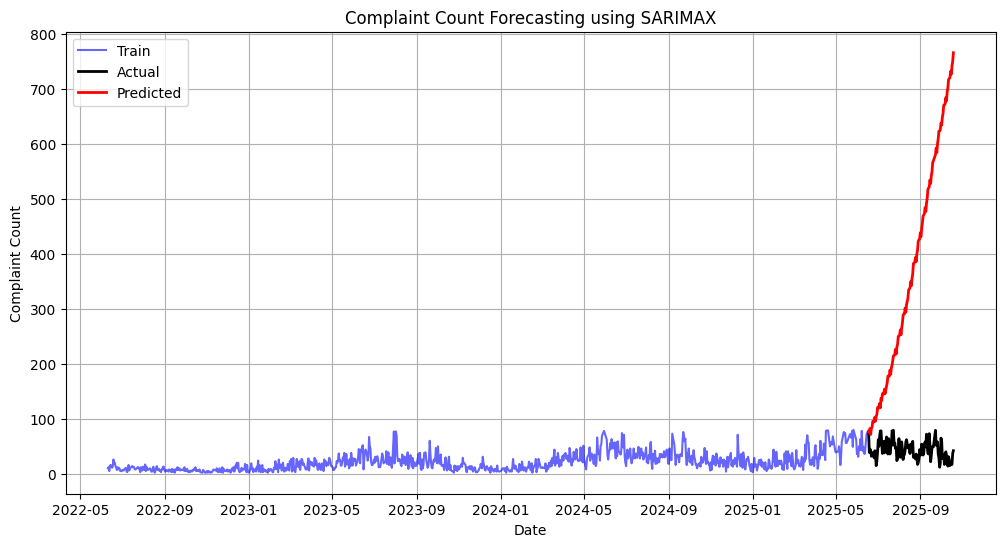

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='blue', alpha=0.6)
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linewidth=2)
plt.title("Complaint Count Forecasting using SARIMAX")
plt.xlabel("Date")
plt.ylabel("Complaint Count")
plt.legend()
plt.grid(True)
plt.show()

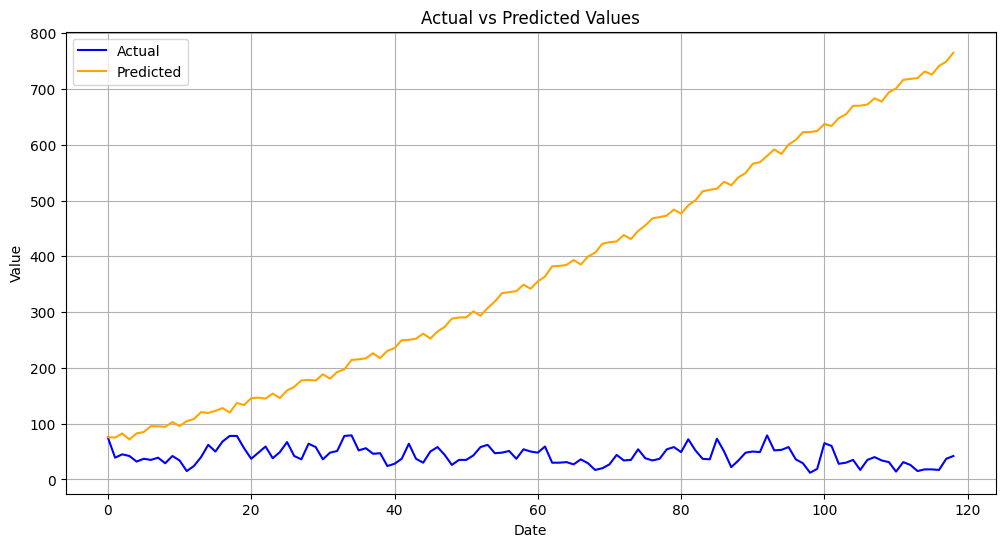

In [31]:
# SARIMAX Model Performance Visualization

# Ensure datetime index
y_test.index = pd.to_datetime(y_test.index)
y_pred.index = pd.to_datetime(y_pred.index)

y_true = np.array(y_test)
y_pred_values = np.array(y_pred)

# 1️⃣ Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred_values, label='Predicted', color='orange')
plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

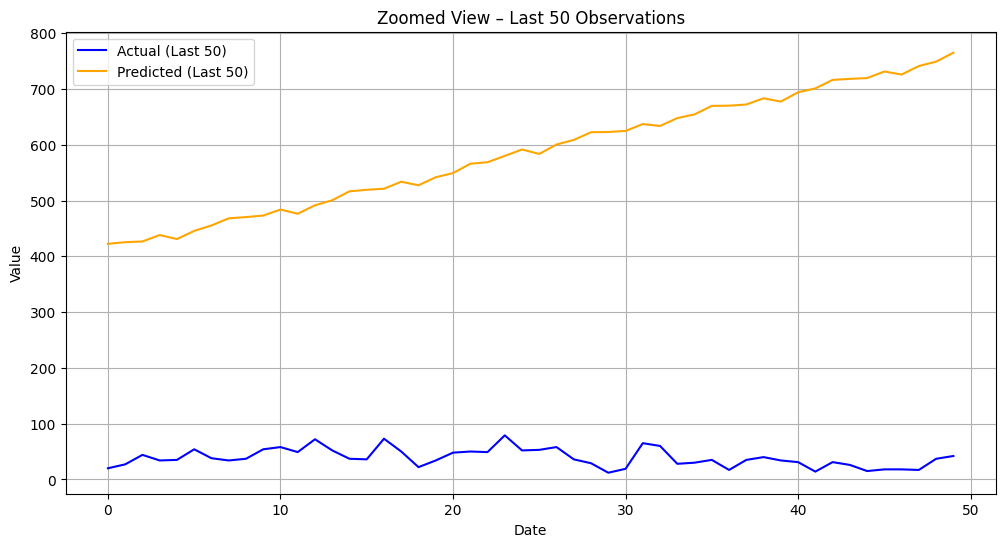

In [32]:
# 2️⃣ Zoomed-in Comparison (Last 50 points)
plt.figure(figsize=(12,6))
plt.plot(y_true[-50:], label='Actual (Last 50)', color='blue')
plt.plot(y_pred_values[-50:], label='Predicted (Last 50)', color='orange')
plt.title("Zoomed View – Last 50 Observations")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()